In [ ]:
import torch

print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.is_available())

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

In [16]:
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu102 _CudaDeviceProperties(name='GeForce GTX 960M', major=5, minor=0, total_memory=2004MB, multi_processor_count=5)


In [2]:
# IMPORT IMAGES FROM roboflow.com and data.yaml 
    # --> this code create test train valid
!curl -L "https://app.roboflow.com/ds/rYtLtTX7vX?key=GKfCsPfLGy" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    941      0 --:--:-- --:--:-- --:--:--   940
100  995k  100  995k    0     0   508k      0  0:00:01  0:00:01 --:--:-- 5298k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/14_png.rf.59f0e9a1024ac18a2df3a9a82c29b255.jpg  
 extracting: test/images/33_png.rf.044ea64ec01b64563d20c11ed751f891.jpg  
 extracting: test/images/3_png.rf.1ce60354a1920241709adffc5bc59857.jpg  
 extracting: test/images/4_png.rf.9141896aa8690883f22aa5bf6d7c8317.jpg  
   creating: test/labels/
 extracting: test/labels/14_png.rf.59f0e9a1024ac18a2df3a9a82c29b255.txt  
 extracting: test/labels/33_png.rf.044ea64ec01b64563d20c11ed751f891.txt  
 extracting: test/labels/3_png.rf.1ce60354a1920241709adffc5bc59857.txt  

In [3]:
# show data.yaml file
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['cars']

In [4]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
# show yolov5 models 
%cat /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/models/yolov5s.yaml 

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [8]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [5]:
#LAST RUN UP
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [7]:
# TRAIN
#train yolov5s on custom data for 100 epochs
#time its performance
%time
%cd /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/
!python train.py --img 416 --batch 2 --epochs 2000 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --cache


mg_size
 1941/1999    0.468G   0.03346    0.0161         0   0.04955         4       416
               Class      Images     Targets           P           R      mAP@.5
                 all           8          29         0.9       0.621         0.7        0.37

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 1942/1999    0.468G   0.03309   0.01755         0   0.05063         6       416
               Class      Images     Targets           P           R      mAP@.5
                 all           8          29         0.9       0.621         0.7        0.37

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
 1943/1999    0.468G   0.03457   0.01765         0   0.05222         9       416
               Class      Images     Targets           P           R      mAP@.5
                 all           8          29         0.9       0.621       0.699       0.362

     Epoch   gpu_mem       box       obj       cls     total  

In [8]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

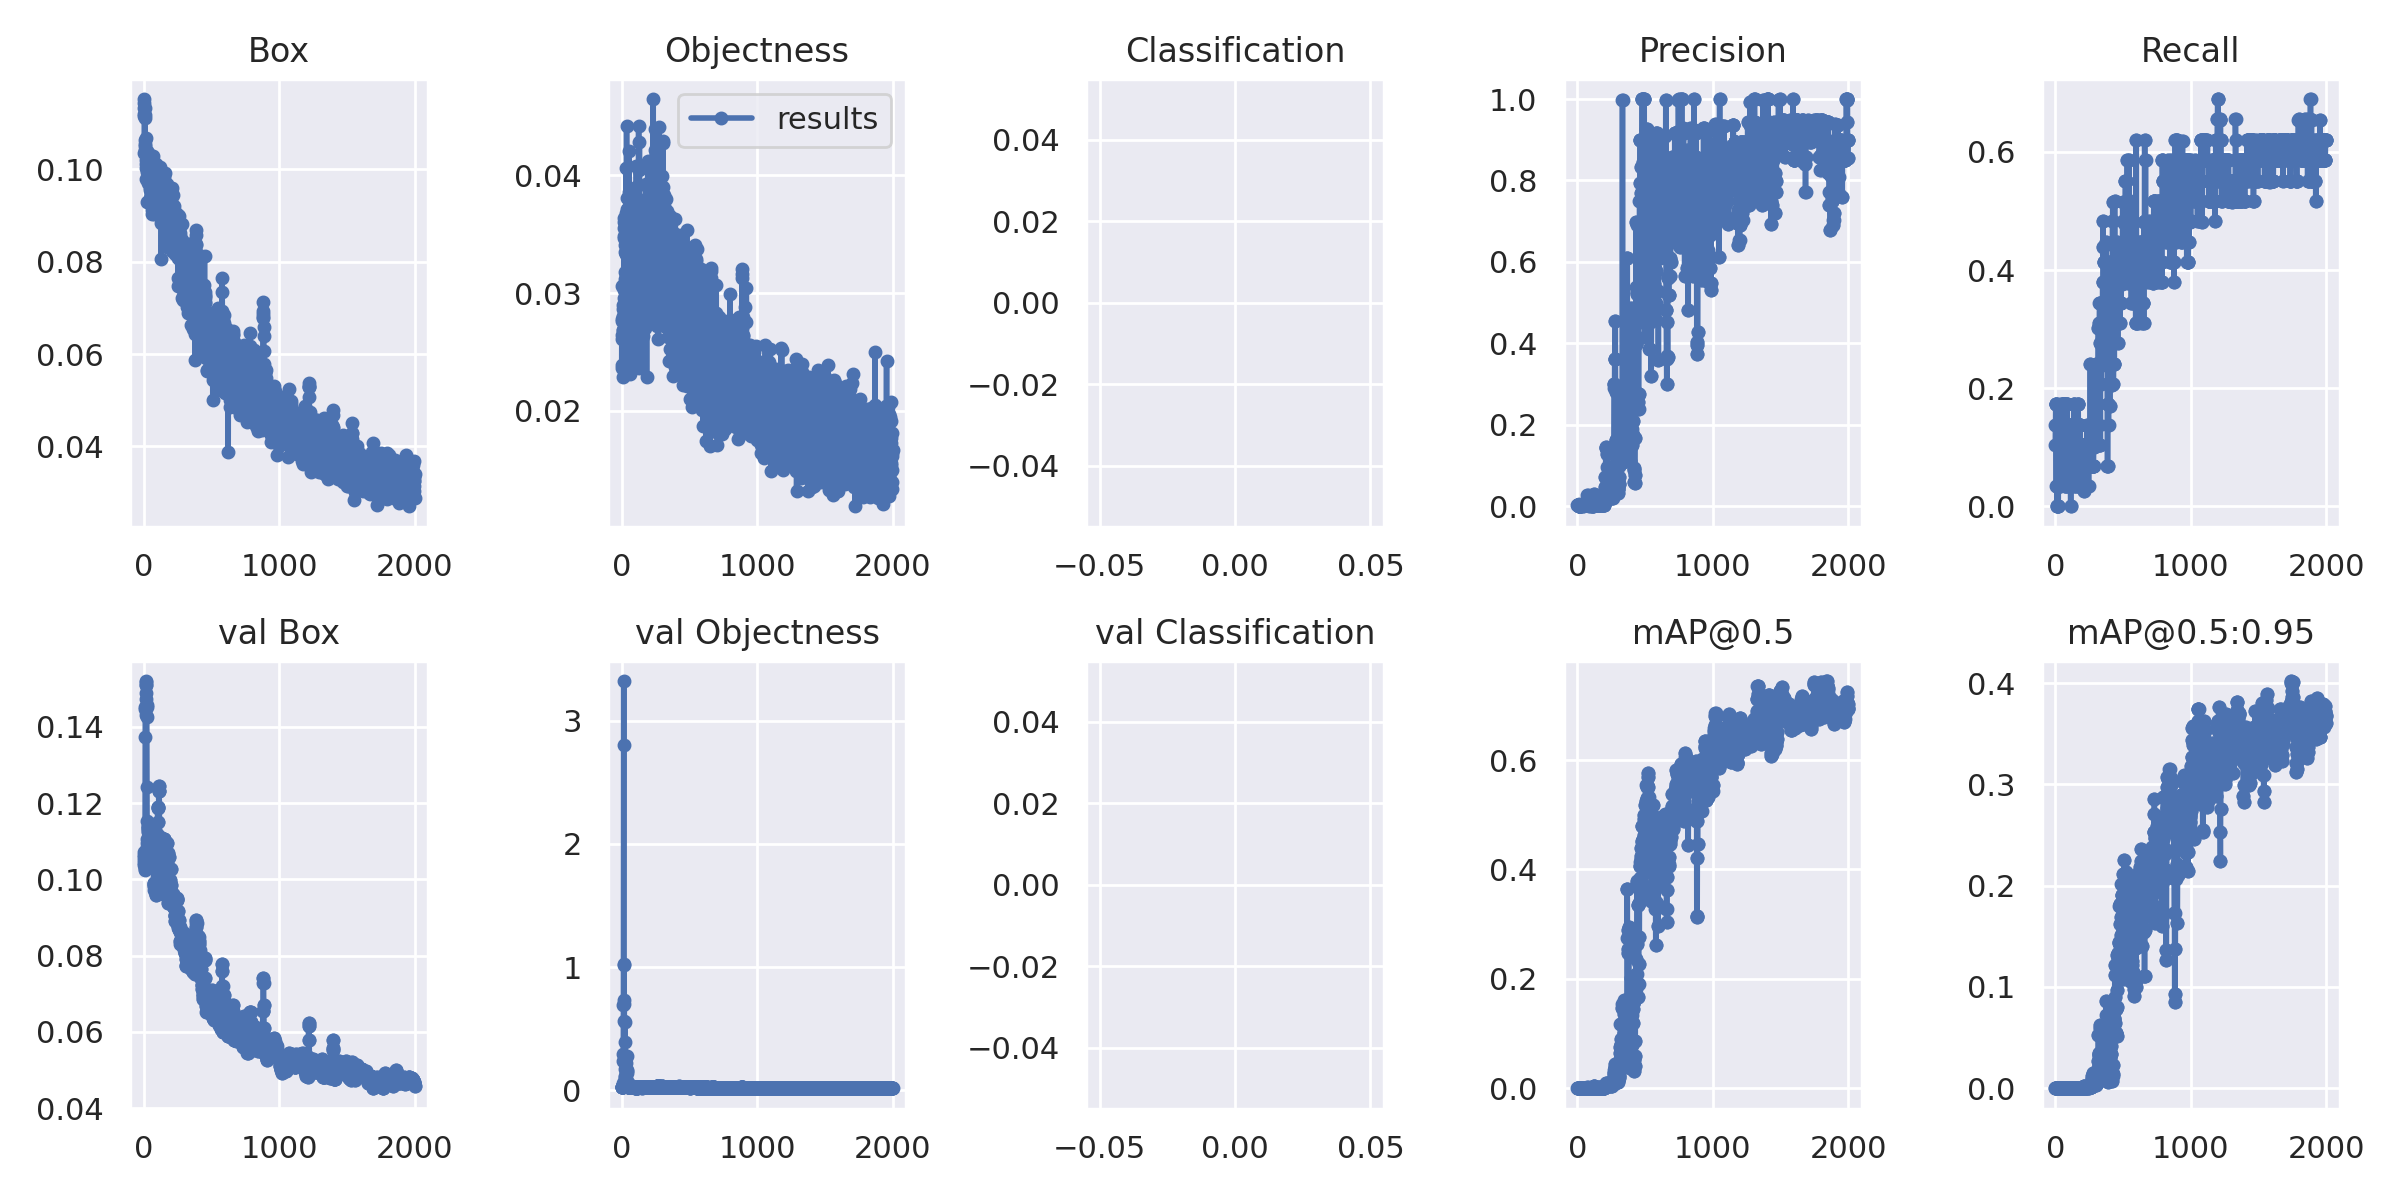

In [17]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/runs/train/yolov5s_results2/results.png', width=100)  # view results.png

# If not work --> run this code:
    #import torch
    #from IPython.display import Image, clear_output  # to       #display images
    #clear_output()

GROUND TRUTH TRAINING DATA:


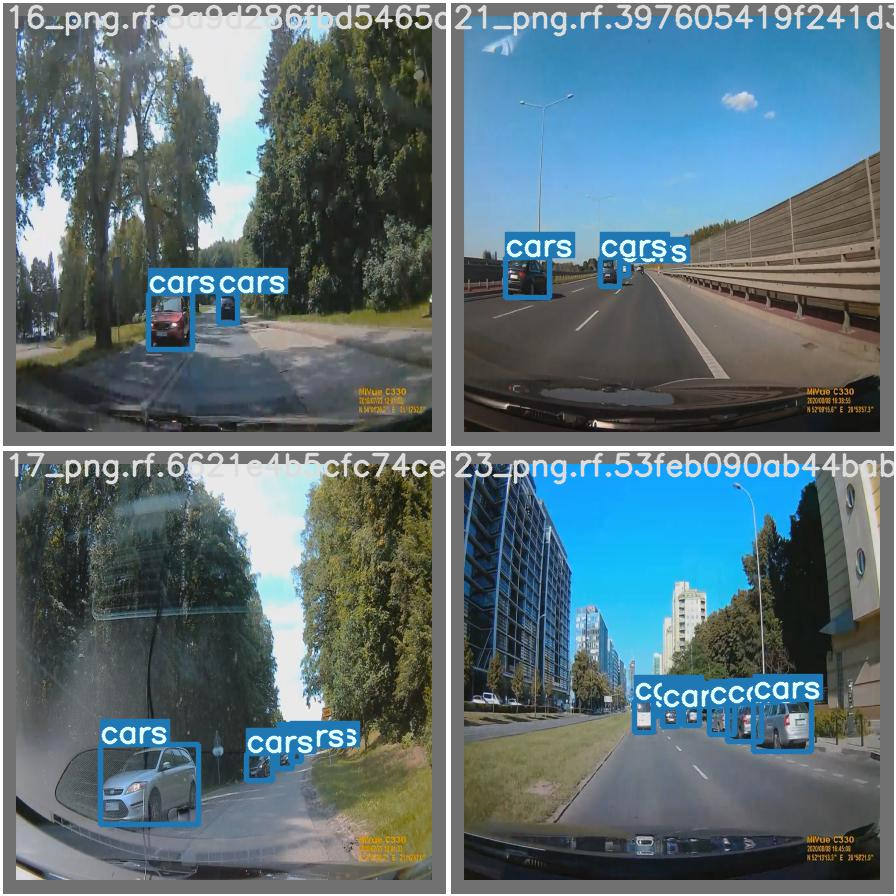

In [19]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/runs/train/yolov5s_results2/test_batch0_labels.jpg', width=800)

GROUND TRUTH AUGMENTED TRAINING DATA:


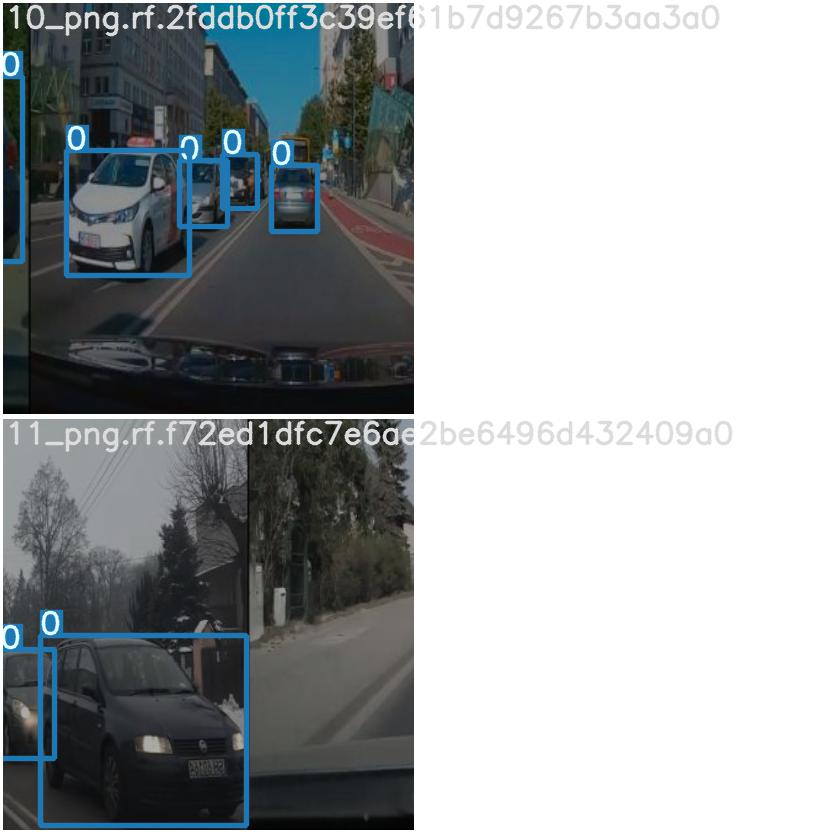

In [20]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

In [21]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [24]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


In [44]:
# DETECT
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.9 --source ../test/images

/home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.9, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results2/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1+cu102 CUDA:0 (GeForce GTX 960M, 2004.5MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
image 1/4 /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/../test/images/14_png.rf.59f0e9a1024ac18a2df3a9a82c29b255.jpg: 416x416 2 carss, Done. (0.021s)
image 2/4 /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/../test/images/33_png.rf.044ea64ec01b64563d20c11ed751f891.jpg: 416x416 1 cars, Done. (0.024s)
image 3/4 /home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/../test/images/3_png.rf.1ce60354a1920241709adffc5bc59857.jpg: 416x416 1 cars, Done. (0.021s)
image 4/4 

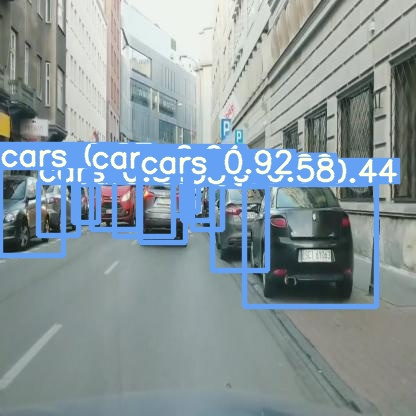

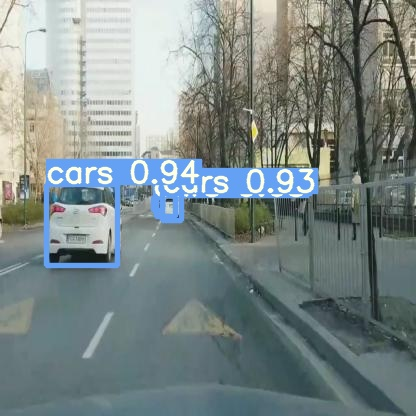

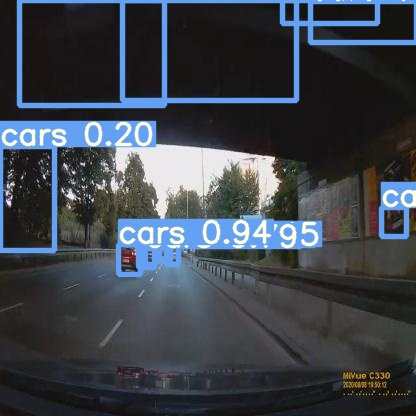

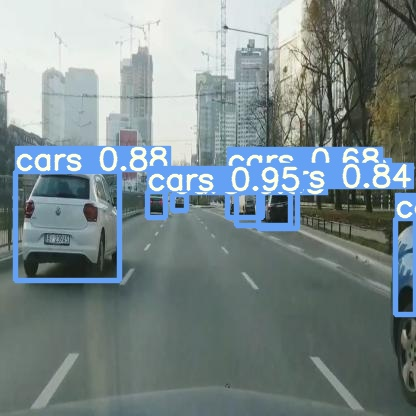

In [40]:
#TEST
#display inference on ALL test images
#this looks much better with longer training above
    #exp --> 0.4
    #exp2 --> 0.6
    #exp3 --> 0.8
    #exp4 --> 0.9

import glob
from IPython.display import Image, display

for imageName in glob.glob('/home/dawid/Politechnika/IC-R/Projekt_ICR/yolov5/runs/detect/exp5/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")